In [1]:
import os
if "otgnn" not in os.getcwd():
    os.chdir("../otgnn/")

import numpy as np
import torch
# device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

from utils import load_model
from models import GCN, compute_ot
from datasets import PropDataset
from graph import MolGraph

from multiprocessing import Pool

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load dataset
# dataset = PropDataset("data/sol/", data_type = "train")
dataset = PropDataset("../iclr19-graph2graph/data/qed", data_type = "wengong")

../iclr19-graph2graph/data/qed   wengong ; split= 0  num total=  88306  num pos= 0


In [3]:
# get molecular graphs for all molecules
# this takes a while
with Pool(24) as p:
    mol_graphs = p.map(MolGraph, dataset)

In [4]:
mol_graphs_lens = [(len(dp.mols[0].atoms), len(dp.mols[1].atoms)) for dp in mol_graphs]
mol_graphs_same = [x for i, x in enumerate(mol_graphs) if mol_graphs_lens[i][0] == mol_graphs_lens[i][1]]
len(mol_graphs_same), len(mol_graphs)

(5975, 88306)

# Get diagnostic stats about number of molecules

In [5]:
len_x = [x for (x, _) in mol_graphs_lens]
len_y = [y for (_, y) in mol_graphs_lens]

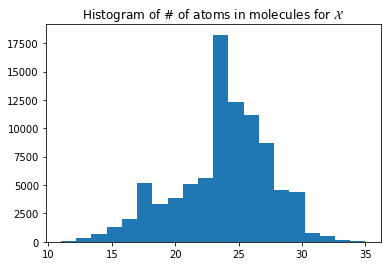

In [51]:
plt.hist(len_x, bins = 20)
plt.title("Histogram of # of atoms in molecules for $\mathcal{X}$")
plt.savefig(path + "num_hist.png")

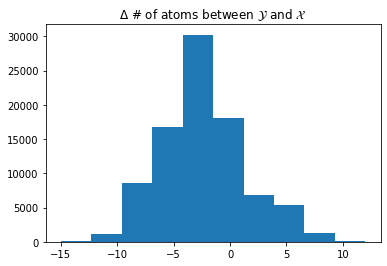

In [50]:
plt.hist([y-x for (x, y) in mol_graphs_lens])
plt.title("$\Delta$ # of atoms between $\mathcal{Y}$ and $\mathcal{X}$")
plt.savefig(path + "delta_hist.png")

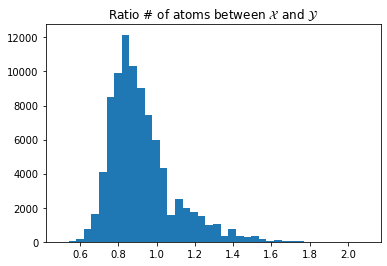

In [49]:
plt.hist([y/x for (x, y) in mol_graphs_lens], bins = 40)
plt.title("Ratio # of atoms between $\mathcal{X}$ and $\mathcal{Y}$")
plt.savefig(path + "ratio_hist.png")

# Visualize

In [16]:
import rdkit.Chem as Chem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D

In [17]:
ds_sample = dataset.data[0:5]

In [19]:
mol_list = [(Chem.MolFromSmiles(x), Chem.MolFromSmiles(y)) for (x,y) in ds_sample]

In [31]:
rdDepictor.Compute2DCoords(mol_list[0][0])

0

In [33]:
x = mol_list[0][0]

In [35]:
display(x)

In [38]:
path = "../images/"
for i in range(3):
    for j in range(2):
        Chem.Draw.MolToFile(mol_list[i][j],path + 'mol_exp_{}_{}.png'.format(i, j))  